In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import shutil
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import Memory
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [2]:
# Get data
#train = pd.read_csv('../../data/train.csv')
train2 = pd.read_csv('../../data/train.csv')
trainIds = train2.loc[:,'Id']
#data_y_SalesPrice = train.pop('SalePrice')
print("train2 : " + str(train2.shape))
testFinal = pd.read_csv('../../data/test.csv')
testIds = testFinal.loc[:,'Id']
print("testFinal : " + str(testFinal.shape))

train2 : (1460, 81)
testFinal : (1459, 80)


In [3]:
train_data = pd.read_csv('../../data/train.csv')

In [4]:
#Months since start
testFinal['MoSinceStart'] = ((testFinal['YrSold'] - min(testFinal['YrSold']))*12) + testFinal['MoSold']
train2['MoSinceStart'] = ((train2['YrSold'] - min(train2['YrSold']))*12) + train2['MoSold']
print(testFinal.index)
prevMonth_dict = dict(testFinal['MoSinceStart'].value_counts())
testFinal['PrevMoSales'] = ((testFinal['MoSinceStart']-1).map(prevMonth_dict) + (testFinal['MoSinceStart']-2).map(prevMonth_dict))/2
testFinal['PrevMoSales'].fillna((testFinal['PrevMoSales'].mean()), inplace=True)
train2_dict = dict(train2['MoSinceStart'].value_counts())
train2['PrevMoSales'] = ((train2['MoSinceStart']-1).map(train2_dict) + (train2['MoSinceStart']-2).map(train2_dict))/2
train2['PrevMoSales'].fillna((train2['PrevMoSales'].mean()), inplace=True)
print(testFinal.index)
testFinal['House_Age'] = testFinal['YrSold'] - testFinal['YearBuilt']
train2['House_Age'] = train2['YrSold'] - train2['YearBuilt']
testFinal['Garage_Age'] = testFinal['YrSold'] - testFinal['GarageYrBlt']
train2['Garage_Age'] = train2['YrSold'] - train2['GarageYrBlt']
print(testFinal.index)
###
#testFinal['BsmtFullBath'].describe()
#temp = pd.DataFrame()
#temp['totalBathrooms'] = (testFinal['FullBath']+testFinal['BsmtFullBath']+(testFinal['BsmtHalfBath']*.5)+(testFinal['HalfBath']*.5))
#print temp                                                                                                          
#testFinal['bed2bath'] = (testFinal['BedroomAbvGr'] / temp['totalBathrooms'])
#testFinal['bed2room'] = (testFinal['BedroomAbvGr']/testFinal['TotRmsAbvGrd'])
#testFinal['bath2room'] = (temp['totalBathrooms']/testFinal['TotRmsAbvGrd'])
##
#temp2 = pd.DataFrame()
#temp2['totalBathrooms'] = (train2['FullBath']+train2['BsmtFullBath']+(train2['BsmtHalfBath']*.5)+(train2['HalfBath']*.5))
#print temp                                                                                                          
#train2['bed2bath'] = (train2['BedroomAbvGr'] / temp2['totalBathrooms'])
#train2['bed2room'] = (train2['BedroomAbvGr']/train2['TotRmsAbvGrd'])
#train2['bath2room'] = (temp2['totalBathrooms']/train2['TotRmsAbvGrd'])


#Drop Year
testFinal.pop('YrSold')
train2.pop('YrSold')

#print data_all[['YrSold','MoSold']]
#print data_all[((data_all['YrSold'] < 2007) or (data_all['MoSold']<=11 and data_all['YrSold'] == 2007))]  

#data_all['RecessionBool'] = np.where((((data_all['MoSold']<=11) & (data_all['YrSold'] == 2007 )) | (data_all['YrSold'] < 2007)  ), 'Before', 'After')  
#test =  data_all[((data_all['MoSold']<=11) & (data_all['YrSold'] == 2007 )) | (data_all['YrSold'] < 2007)  ]  
#print data_all.shape
#print data_all['RecessionBool']

RangeIndex(start=0, stop=1459, step=1)
RangeIndex(start=0, stop=1459, step=1)
RangeIndex(start=0, stop=1459, step=1)


0       2008
1       2007
2       2008
3       2006
4       2008
5       2009
6       2007
7       2009
8       2008
9       2008
10      2008
11      2006
12      2008
13      2007
14      2008
15      2007
16      2010
17      2006
18      2008
19      2009
20      2006
21      2007
22      2008
23      2007
24      2010
25      2009
26      2010
27      2010
28      2006
29      2008
        ... 
1430    2006
1431    2009
1432    2007
1433    2008
1434    2006
1435    2008
1436    2007
1437    2008
1438    2010
1439    2007
1440    2008
1441    2008
1442    2009
1443    2009
1444    2007
1445    2007
1446    2010
1447    2007
1448    2007
1449    2006
1450    2009
1451    2009
1452    2006
1453    2006
1454    2009
1455    2007
1456    2010
1457    2010
1458    2010
1459    2008
Name: YrSold, Length: 1460, dtype: int64

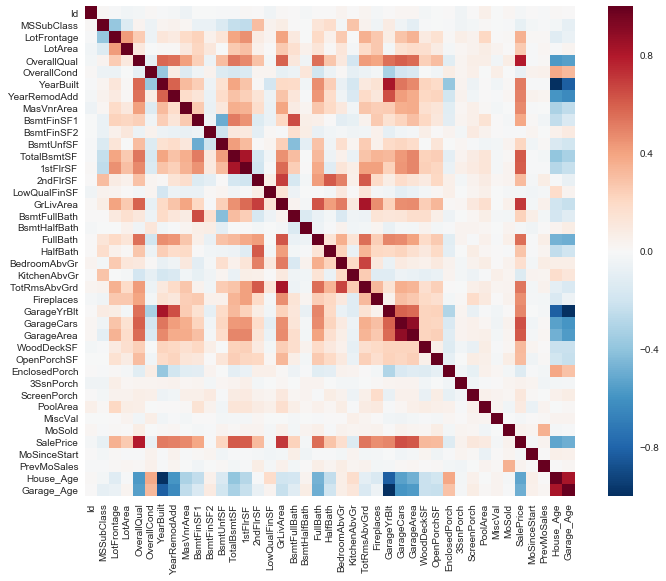

In [5]:
#correlation matrix
corrmat = train2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

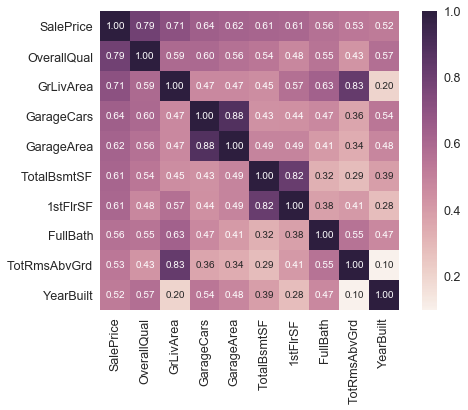

In [6]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

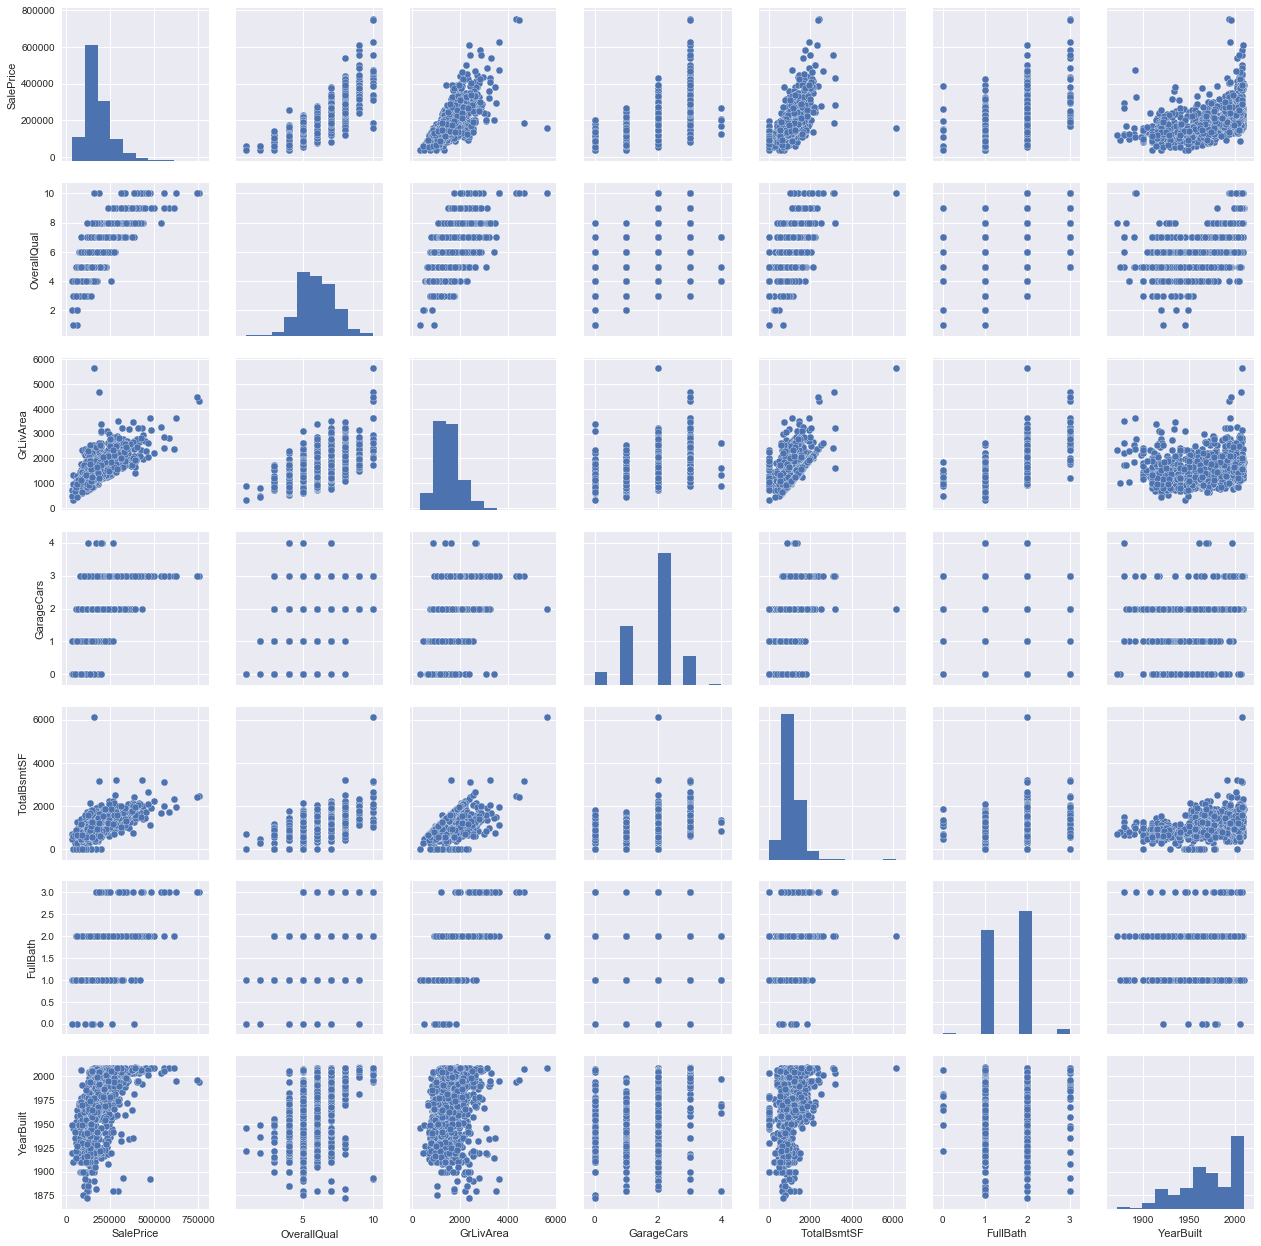

In [7]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train2[cols], size = 2.5)
plt.show();

In [8]:
#missing data
total = train2.isnull().sum().sort_values(ascending=False)
percent = (train2.isnull().sum()/train2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
Garage_Age,81,0.055
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageQual,81,0.055


In [9]:
#dealing with missing data
train2 = train2.drop((missing_data[missing_data['Total'] > 1]).index,1)
train2 = train2.drop(train2.loc[train2['Electrical'].isnull()].index)
train2.isnull().sum().max() #just checking that there's no missing data missing...



0

In [10]:
testFinal.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu       730
GarageType         76
GarageYrBlt        78
GarageFinish       78
GarageCars          1
GarageArea          1
GarageQual         78
GarageCond         78
PavedDrive          0
WoodDeckSF          0
OpenPorchS

In [11]:
#Reconcile columns

print (len(train2.columns), len(testFinal.columns))
test = train2.columns.values
index = np.argwhere(test=='SalePrice')
#test = train2.copy(deep=True)
#test.pop('SalePrice')
testFinal = testFinal[np.delete(test,index)]
#print len(testFinal.columns)
print(testFinal)

65 83
        Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
0     1461          20       RH    11622   Pave      Reg         Lvl   
1     1462          20       RL    14267   Pave      IR1         Lvl   
2     1463          60       RL    13830   Pave      IR1         Lvl   
3     1464          60       RL     9978   Pave      IR1         Lvl   
4     1465         120       RL     5005   Pave      IR1         HLS   
5     1466          60       RL    10000   Pave      IR1         Lvl   
6     1467          20       RL     7980   Pave      IR1         Lvl   
7     1468          60       RL     8402   Pave      IR1         Lvl   
8     1469          20       RL    10176   Pave      Reg         Lvl   
9     1470          20       RL     8400   Pave      Reg         Lvl   
10    1471         120       RH     5858   Pave      IR1         Lvl   
11    1472         160       RM     1680   Pave      Reg         Lvl   
12    1473         160       RM     1680   Pave      Reg  

In [12]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train2['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


/Users/grantpendrey/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


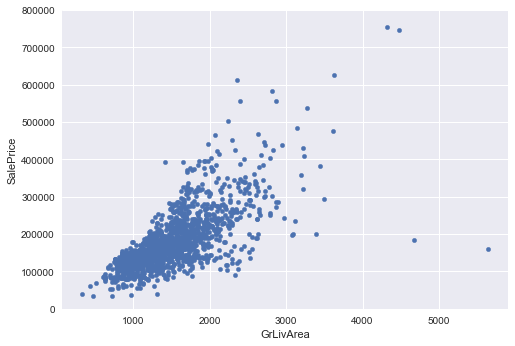

In [13]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train2['SalePrice'], train2[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [14]:
#deleting outlier points
train2.sort_values(by = 'GrLivArea', ascending = False)[:2]
train2 = train2.drop(train2[train2['Id'] == 1299].index)
train2 = train2.drop(train2[train2['Id'] == 524].index)

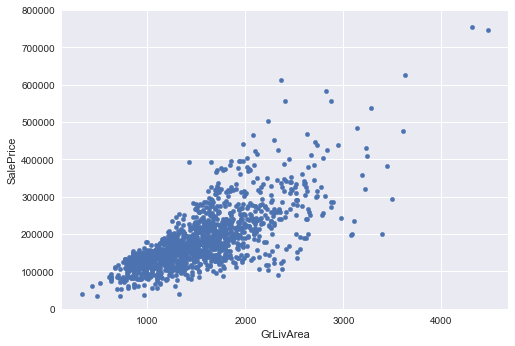

In [15]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train2['SalePrice'], train2[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [16]:
train2 = train2.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45",50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
          })

testFinal = testFinal.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
          })


In [17]:
train2['SalePrice'] = np.log1p(train2['SalePrice'])

In [18]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
train2['HasBsmt'] = pd.Series(len(train2['TotalBsmtSF']), index=train2.index)
train2['HasBsmt'] = "No" 
train2.loc[train2['TotalBsmtSF']>0,'HasBsmt'] = "Yes"

testFinal['HasBsmt'] = pd.Series(len(testFinal['TotalBsmtSF']), index=testFinal.index)
testFinal['HasBsmt'] = "No"  
testFinal.loc[testFinal['TotalBsmtSF']>0,'HasBsmt'] = "Yes"


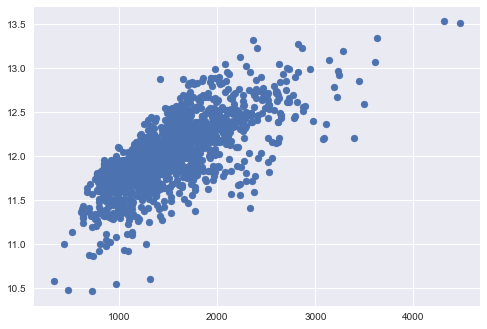

In [19]:
#scatter plot
plt.scatter(train2['GrLivArea'], train2['SalePrice']);

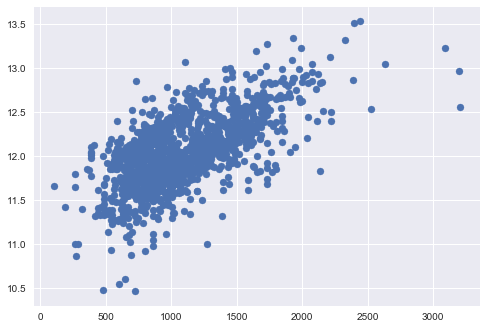

In [20]:
#scatter plot
plt.scatter(train2[train2['TotalBsmtSF']>0]['TotalBsmtSF'], train2[train2['TotalBsmtSF']>0]['SalePrice']);

In [21]:
#convert categorical variable into dummy
data_y_SalesPrice = train2.pop('SalePrice')
print (data_y_SalesPrice.describe())
print (len(train2.columns), len(testFinal.columns))



count   1457.000
mean      12.024
std        0.400
min       10.460
25%       11.775
50%       12.002
75%       12.274
max       13.534
Name: SalePrice, dtype: float64
65 65


In [22]:
data_all = pd.concat([train2, testFinal], axis=0)

print(len(data_all.columns))
data_all.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'], axis=1,inplace=True)
print(len(data_all.columns))


65
62


In [23]:
#Differentiate numerical features (minus the target) and categorical features
categorical_features = data_all.select_dtypes(include = ["object"]).columns
numerical_features = data_all.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
data_all_num = data_all[numerical_features]
data_all_cat = data_all[categorical_features]

Numerical features : 31
Categorical features : 31


In [24]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = data_all_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
data_all[skewed_features] = np.log1p(data_all_num[skewed_features])

17 skewed numerical features to log transform


/Users/grantpendrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log1p
  


In [25]:
data_all_cat = pd.get_dummies(data_all_cat)

In [26]:
data_all = pd.concat([data_all_cat, data_all_num], axis=1)

In [27]:
train = data_all.iloc[0:train2.shape[0],:]
testFinal = data_all.iloc[train2.shape[0]:,:]

In [28]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
House_Age,0,0.000
HouseStyle_2.5Fin,0,0.000
HouseStyle_1.5Unf,0,0.000
HouseStyle_1.5Fin,0,0.000
BldgType_TwnhsE,0,0.000
BldgType_Twnhs,0,0.000
BldgType_Duplex,0,0.000
BldgType_2fmCon,0,0.000
BldgType_1Fam,0,0.000
Condition2_RRNn,0,0.000


In [29]:
#missing data
total = testFinal.isnull().sum().sort_values(ascending=False)
percent = (testFinal.isnull().sum()/testFinal.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
BsmtFullBath,2,0.001
BsmtHalfBath,2,0.001
GarageCars,1,0.001
BsmtFinSF1,1,0.001
BsmtUnfSF,1,0.001
BsmtFinSF2,1,0.001
TotalBsmtSF,1,0.001
Condition2_RRNn,0,0.000
Condition2_RRAn,0,0.000
Condition2_RRAe,0,0.000


In [30]:
testFinal = testFinal.fillna(0)
train = train.fillna(0)

In [31]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
House_Age,0,0.000
HouseStyle_2.5Fin,0,0.000
HouseStyle_1.5Unf,0,0.000
HouseStyle_1.5Fin,0,0.000
BldgType_TwnhsE,0,0.000
BldgType_Twnhs,0,0.000
BldgType_Duplex,0,0.000
BldgType_2fmCon,0,0.000
BldgType_1Fam,0,0.000
Condition2_RRNn,0,0.000


In [32]:
#missing data
total = testFinal.isnull().sum().sort_values(ascending=False)
percent = (testFinal.isnull().sum()/testFinal.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
House_Age,0,0.000
HouseStyle_2.5Fin,0,0.000
HouseStyle_1.5Unf,0,0.000
HouseStyle_1.5Fin,0,0.000
BldgType_TwnhsE,0,0.000
BldgType_Twnhs,0,0.000
BldgType_Duplex,0,0.000
BldgType_2fmCon,0,0.000
BldgType_1Fam,0,0.000
Condition2_RRNn,0,0.000


In [33]:
#testFinal['Id']
#train2['Id']
testFinal.pop('Id')
train.pop('Id')

0          1
1          2
2          3
3          4
4          5
5          6
6          7
7          8
8          9
9         10
10        11
11        12
12        13
13        14
14        15
15        16
16        17
17        18
18        19
19        20
20        21
21        22
22        23
23        24
24        25
25        26
26        27
27        28
28        29
29        30
        ... 
1430    1431
1431    1432
1432    1433
1433    1434
1434    1435
1435    1436
1436    1437
1437    1438
1438    1439
1439    1440
1440    1441
1441    1442
1442    1443
1443    1444
1444    1445
1445    1446
1446    1447
1447    1448
1448    1449
1449    1450
1450    1451
1451    1452
1452    1453
1453    1454
1454    1455
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1457, dtype: int64

In [34]:
# Partition the dataset in train + validation sets
#categorical_features = testFinal.select_dtypes(include = ["object"]).columns
#numerical_features = testFinal.select_dtypes(exclude = ["object"]).columns
X_train, X_test, y_train, y_test = train_test_split(train, data_y_SalesPrice, test_size = 0.3, random_state = 5)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 246)
X_test : (438, 246)
y_train : (1019,)
y_test : (438,)


In [35]:
train.select_dtypes(exclude = ["object"]).columns

Index(['MSSubClass_SC120', 'MSSubClass_SC150', 'MSSubClass_SC160',
       'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC20',
       'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45',
       'MSSubClass_SC50',
       ...
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSinceStart', 'PrevMoSales',
       'House_Age'],
      dtype='object', length=246)

In [36]:
print(len(numerical_features))
print(numerical_features)
numerical_features =  numerical_features.drop(['Id'])

31
Index(['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSinceStart', 'PrevMoSales',
       'House_Age'],
      dtype='object')


In [37]:
print(len(numerical_features))
print(numerical_features)

30
Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSinceStart', 'PrevMoSales',
       'House_Age'],
      dtype='object')


In [38]:
# Standardize numerical features
stdSc = StandardScaler()

numerical_features = numerical_features.drop('MoSinceStart')
#numeric_features = numerical_features.drop('PrevMoSales')
numerical_features = numerical_features.drop('House_Age')
print(numerical_features)

X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])
testFinal.loc[:, numerical_features] = stdSc.transform(testFinal.loc[:, numerical_features])

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'PrevMoSales'],
      dtype='object')


/Users/grantpendrey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
X_train['MoSinceStart'].describe()

count   1019.000
mean      28.196
std       15.766
min        1.000
25%       16.000
50%       29.000
75%       42.000
max       55.000
Name: MoSinceStart, dtype: float64

In [40]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 19.5
Ridge RMSE on Training set : 0.114426582402
Ridge RMSE on Test set : 0.12308077306
Ridge RMSE on Training set : 0.114135523062
Ridge RMSE on Test set : 0.123240828395


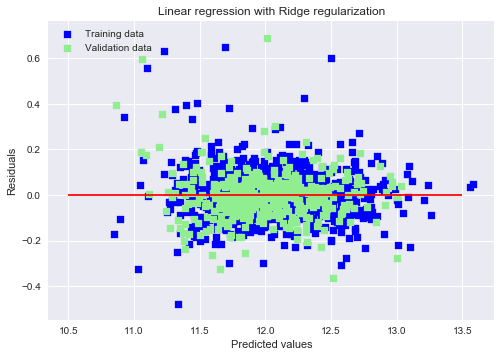

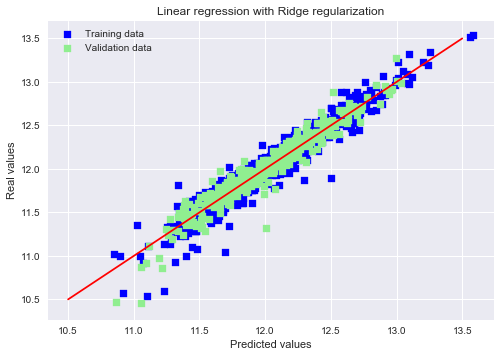

Ridge picked 237 features and eliminated the other 9 features


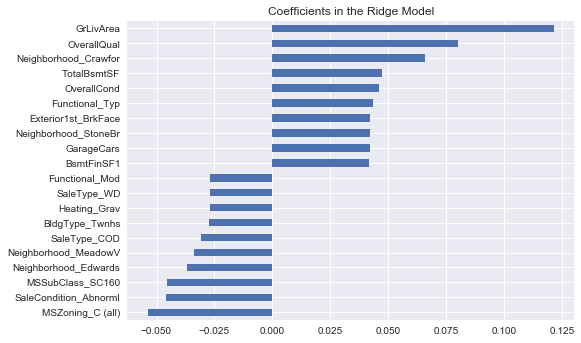

Ridge picked 245 features and eliminated the other 1 features


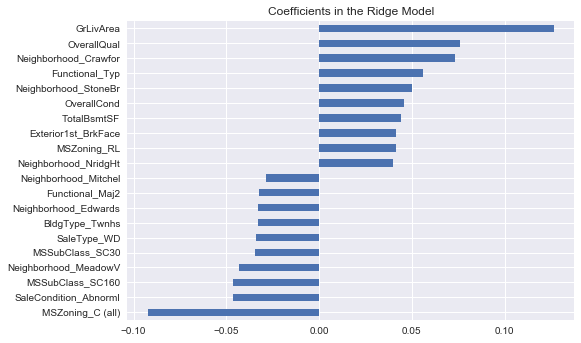

In [41]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60,80,100])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 5)
ridge.fit(X_train, y_train)
ridge_alpha_final = ridge.alpha_
print("Best alpha :", ridge_alpha_final)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

######
ridge2 = Ridge(alpha = ridge_alpha_final)
x_final = pd.concat([X_train, X_test], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)
ridge2.fit(x_final, y_final)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge2).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge2).mean())
y_train_rdg = ridge2.predict(X_train)
y_test_rdg = ridge2.predict(X_test)
#######


# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge2.coef_, index = x_final.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Best l1_ratio : 0.1
Best alpha : 0.003
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.085
Best alpha : 0.006
Now try again for more precision on alpha, with l1_ratio fixed at 0.085 and alpha centered around 0.006
Best l1_ratio : 0.085
Best alpha : 0.0048
ElasticNet RMSE on Training set : 0.114437040609
ElasticNet RMSE on Test set : 0.119733448996
ElasticNet RMSE on Training set : 0.113565758554
ElasticNet RMSE on Test set : 0.119558193353


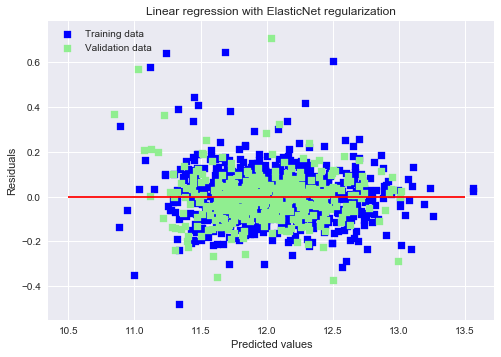

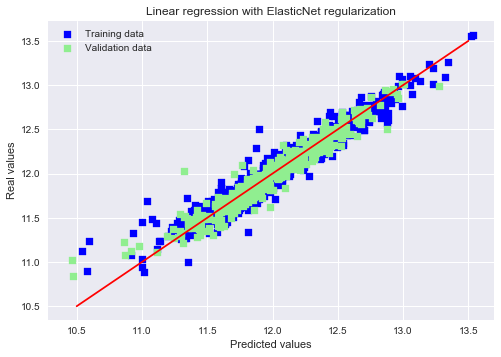

ElasticNet picked 113 features and eliminated the other 133 features


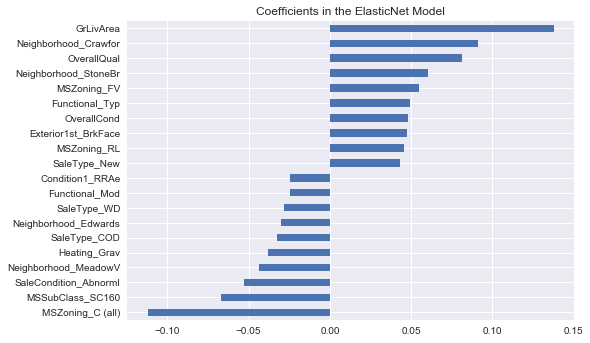

ElasticNet picked 108 features and eliminated the other 138 features


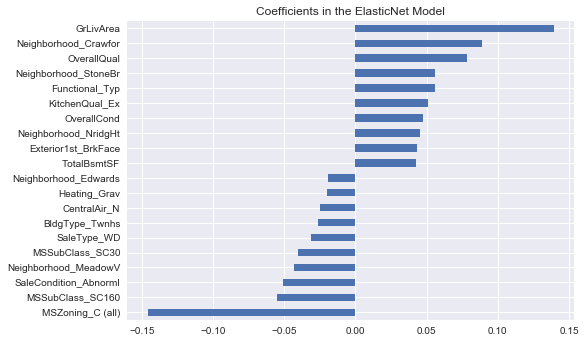

In [42]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
EN_alpha_final = elasticNet.alpha_
EN_ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", EN_ratio)
print("Best alpha :", EN_alpha_final )



print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

######
elasticNet2 = ElasticNet(alpha = EN_alpha_final, l1_ratio = EN_ratio)
x_final = pd.concat([X_train, X_test], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)
elasticNet2.fit(x_final, y_final)

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet2).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet2).mean())
y_train_ela = elasticNet2.predict(X_train)
y_test_ela = elasticNet2.predict(X_test)
#######

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet2.coef_, index = x_final.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [43]:
#lasso_cv = LassoCV(alphas=alphas, random_state=0)
k_fold = KFold(3)
    
    
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],
                          max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
   
lasso_alpha_final = lasso.alpha_
print("Best alpha :", lasso_alpha_final )

Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 0.085
Best alpha : 0.00048


In [44]:

import datetime
import numpy as np
import pandas as pd

# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew

start_time = datetime.datetime.now()

################################################################################
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append(np.exp(regressor.predict(X).ravel()))

        return np.log1p(np.mean(self.predictions_, axis=0))
        
################################################################################

# RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

/Users/grantpendrey/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [45]:
def evaludate_model(model, x, y):
    print('Cross_validation..')
    n_splits_val = 3
    kf = KFold(n_splits=n_splits_val, shuffle=False)
    idx = 0
    rmse_buf = np.empty(n_splits_val)
    for train, test in kf.split(x):
        model.fit(x.iloc[train], y.iloc[train])
        y_cv = model.predict(x.iloc[test])
        rmse_buf[idx] = rmse(y.iloc[test], y_cv)
        print('Interation #' + str(idx) + ': RMSE = %.5f' % rmse_buf[idx])
        idx += 1

    mean_rmse = np.mean(rmse_buf)
    print('   Mean RMSE = %.5f' % mean_rmse + ' +/- %.5f' % np.std(rmse_buf))

    return mean_rmse

def evaludate_submodels(models, x, y):
    print('Cross_validation..')
    n_splits_val = 10
    kf = KFold(n_splits=n_splits_val, shuffle=False)
    for m_i, model in enumerate(models.regressors): 
        rmse_buf = np.empty(n_splits_val)
        idx = 0
        for train, test in kf.split(x):
            model.fit(x.iloc[train], y.iloc[train])
            y_cv = model.predict(x.iloc[test])
            rmse_buf[idx] = rmse(y.iloc[test], y_cv)
            # print('Interation #' + str(idx) + ': RMSE = %.5f' % rmse_buf[idx])
            idx += 1

        mean_rmse = np.mean(rmse_buf)
        print('Model #' + str(m_i) + ': mean RMSE = %.5f' % mean_rmse + \
            ' +/- %.5f' % np.std(rmse_buf))

In [46]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
       
        'alpha': list(np.arange(0.05, .1, 0.01)),
        #'alpha': [0.09],
        'degree': list(np.arange(1.8, 2, .1)),
        #'degree': [1.75],
        'coef0': list(np.arange(0.5, 2.0, .2)),
        #'coef0': [1.5],
        #'fit_intercept': [True,False],
        #'normalize': [True,False],
        #'alpha': [0.008]
        #'alpha_2': list(np.arange(1e-7, 2e-6, 3e-7))
        #'alpha_2': [0.00000008]
        'kernel': ['polynomial']    
    },
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

#alpha=0.3, kernel='polynomial', degree=2, coef0=1.85
grid_reg = KernelRidge()
# train across 10 folds
grid_search = GridSearchCV(grid_reg, param_grid, cv=10,
                           scoring=scorer,n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

KR_alpha = grid_search.best_estimator_.alpha
KR_adegree = grid_search.best_estimator_.degree
KR_acoef0 = grid_search.best_estimator_.coef0
KR_akernel = grid_search.best_estimator_.kernel
print(KR_alpha,KR_adegree,KR_acoef0,KR_akernel)
#KernelRidge

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   31.1s


{'alpha': 0.080000000000000016, 'coef0': 1.4999999999999998, 'degree': 1.8, 'kernel': 'polynomial'}
0.08 1.8 1.5 polynomial


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   31.7s finished


In [47]:
regr1 = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)


regr2 = Lasso(alpha=lasso_alpha_final, max_iter=50000)

regr3 = ElasticNet(alpha=EN_alpha_final,l1_ratio=EN_ratio)

regr4 = KernelRidge(alpha=0.3, kernel='polynomial', degree=2, coef0=1.85)



ensemble1 = CustomEnsembleRegressor([ regr1,regr2, regr3, regr4])



x_final = pd.concat([X_train, X_test], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)



# Evaluation was commented to make it run as  kernel
print('Evaluating each model separately..')
evaludate_submodels(ensemble1, X_train, y_train)


print('Evaluating ensemble..')
evaludate_model(ensemble1, X_train, y_train)

print('Fitting ensemble and predicting..')
# Fit the ensemble
ensemble1.fit(X_train, y_train)


#print("Ensamble RMSE on Training set :", rmse_cv_train(regr).mean())
print("Ensamble RMSE on Test set :", rmse_cv_test(ensemble1).mean())



#print(pd.DataFrame(np.exp(regrtest1.predict(X_test))).head(10))
 

Evaluating each model separately..
Cross_validation..
Model #0: mean RMSE = 0.11788 +/- 0.01827
Model #1: mean RMSE = 0.11434 +/- 0.01787
Model #2: mean RMSE = 0.11357 +/- 0.01642
Model #3: mean RMSE = 0.12239 +/- 0.01958
Evaluating ensemble..
Cross_validation..
Interation #0: RMSE = 0.11325
Interation #1: RMSE = 0.12082
Interation #2: RMSE = 0.10916
   Mean RMSE = 0.11441 +/- 0.00483
Fitting ensemble and predicting..
Ensamble RMSE on Test set : 0.116498707592


In [48]:
#Predict automl
testFinalPred = np.exp(ensemble1.predict(testFinal))
#print(testFinalPred.describe())
#print(testFinalPred.head())
#print(testIds)
dfSubmissions = pd.DataFrame(list(zip(testIds, testFinalPred)), columns=['Id', 'SalePrice'])
print(dfSubmissions.head())
dfSubmissions['SalePrice'].describe()
#dfSubmissions.head()

     Id  SalePrice
0  1461 116166.263
1  1462 162361.316
2  1463 181215.075
3  1464 195727.267
4  1465 198447.439


count      1459.000
mean     179130.617
std       86116.542
min       44509.135
25%      124988.749
50%      157045.801
75%      211422.771
max     1634562.004
Name: SalePrice, dtype: float64

In [50]:
#outFile = '../../data/submissions/Grant_20170717_test_submission_2.csv'
#dfSubmissions.to_csv(outFile, index=False)